# Setup

## Imports

In [1]:
from vaiutils import path_consts, plot_images, channels_last
from tqdm import tqdm_notebook

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST

## Load data and variables

In [3]:
for k, v in path_consts('InfoGAN', 'MNIST'):
    exec(k + '=v')

In [4]:
batch_size = 32
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data = DataLoader(MNIST(DIR_DATA, transform=transform),
                  batch_size=batch_size, shuffle=True, drop_last=True)

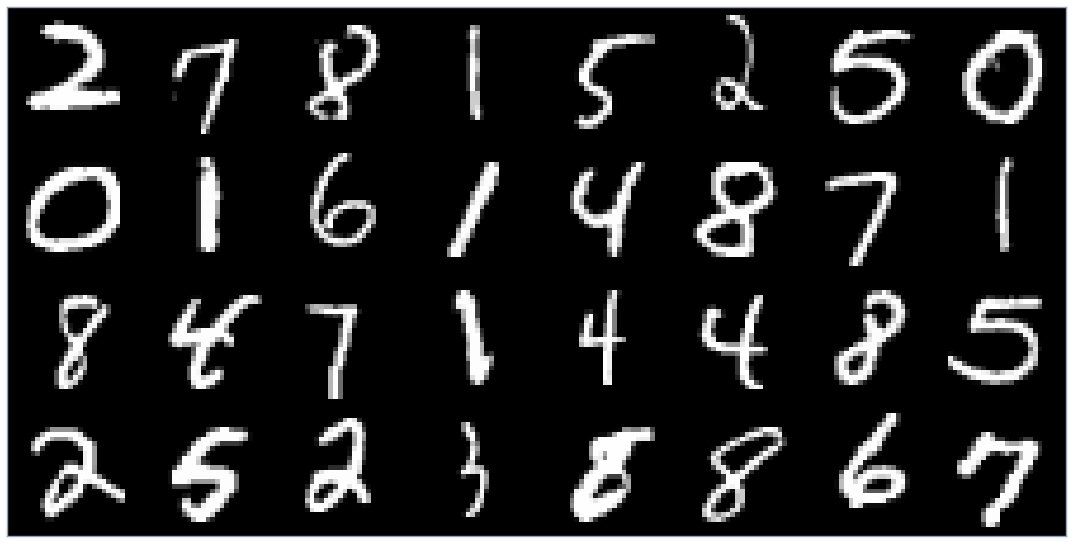

In [5]:
plot_images(channels_last(iter(data).next()[0].numpy()))

# Create Model

In [34]:
z_dim = 32
c_dim = 10
c_size = 1

In [35]:
def init_weights(model):
    for m in model.modules():
        if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
            nn.init.normal(m.weight.data, std=0.02)
        elif type(m) == nn.BatchNorm2d:
            nn.init.normal(m.weight.data, mean=1, std=0.02)

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5, 2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 5, 2, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256 * 7 * 7, 1)
        init_weights(self)

    def lrelu(self, x):
        return F.leaky_relu(x, 0.2, inplace=True)

    def forward(self, x):
        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.bn1(self.conv2(x)))
        x = self.lrelu(self.bn2(self.conv3(x)))
        x = self.lrelu(self.bn3(self.conv4(x)))
        x = x.view(-1, 256 * 7 * 7)
        return x, F.sigmoid(self.fc(x)).squeeze()

In [37]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim + c_dim*c_size, 256 * 7 * 7)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv1 = nn.ConvTranspose2d(
            256, 128, 5, 2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.ConvTranspose2d(
            128, 64, 5, 2, padding=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.ConvTranspose2d(64, 32, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv4 = nn.ConvTranspose2d(32, 1, 5, padding=2)
        init_weights(self)

    def relu(self, x):
        return F.relu(x, inplace=True)

    def forward(self, z, c):
        x = torch.cat([z] + [c_i for c_i in c], 1)
        x = self.relu(self.bn1(self.fc(x).view(-1, 256, 7, 7)))
        x = self.relu(self.bn2(self.conv1(x)))
        x = self.relu(self.bn3(self.conv2(x)))
        x = self.relu(self.bn4(self.conv3(x)))
        return F.tanh(self.conv4(x))

In [38]:
class Q(nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        self.fc = []
        for i in range(c_size):
            self.add_module('fc'+str(i),nn.Linear(256 * 7 * 7, c_dim))
        init_weights(self)

    def forward(self, x):
        return_list = []
        for fc_layer in self.children():
            return_list.append(fc_layer(x))
        return return_list

# Train Model

In [39]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
q = Q().cuda()

optimizer_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(),
                         lr=2e-4, betas=(0.5, 0.999))
optimizer_q = optim.Adam(list(generator.parameters()) + list(q.parameters()),
                         lr=2e-4, betas=(0.5, 0.999))

criterion = nn.BCELoss()
q_criterion = nn.CrossEntropyLoss()

In [40]:
def one_hot(x, num_classes):
    num_samples = x.data.cpu().shape[0]
    y = torch.zeros(num_samples, num_classes)
    y[range(num_samples), x.data.cpu()] = 1
    return Variable(y.cuda())

In [41]:
history = {'loss_g': [], 'loss_d': [], 'loss_q': []}


def optimize(epochs=1):
    y_0 = Variable(torch.zeros(batch_size).cuda())
    y_1 = Variable(torch.ones(batch_size).cuda())
    for epoch in tqdm_notebook(range(epochs)):
        for batch, datum in enumerate(tqdm_notebook(data)):
            x_batch = Variable(datum[0].cuda())
            z_batch = Variable(torch.rand(batch_size, z_dim).cuda() * 2 - 1)
            c_batch=[]
            for _ in range(c_size):
                c_batch.append(Variable(torch.multinomial(torch.Tensor([1 / c_dim] * c_dim), batch_size, replacement=True).cuda
                                ()))

            x_gen = generator(z_batch, [one_hot(c, c_dim) for c in c_batch])
            _, p_real = discriminator(x_batch)
            d_fake, p_fake = discriminator(x_gen)
            q_c1x = q(d_fake)

            optimizer_d.zero_grad()
            loss_d = criterion(p_real, y_1) + criterion(p_fake, y_0)
            loss_d.backward(retain_graph=True)
            optimizer_d.step()

            optimizer_g.zero_grad()
            loss_g = criterion(p_fake, y_1)
            loss_g.backward(retain_graph=True)
            optimizer_g.step()

            optimizer_q.zero_grad()
            loss_q=0
            for i in range(c_size):
                loss_q += q_criterion(q_c1x[i], c_batch[i])
            loss_q.backward()
            optimizer_q.step()

            if batch % 100 == 0:
                history['loss_d'].append(loss_d.cpu().data.numpy()[0])
                history['loss_g'].append(loss_g.cpu().data.numpy()[0])
                history['loss_q'].append(loss_q.cpu().data.numpy()[0])

            if batch % 500 == 0:
                plot_images(channels_last(x_gen[:5].cpu().data.numpy()))

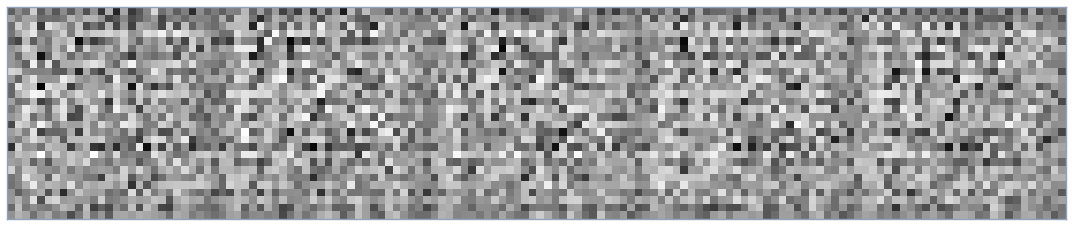

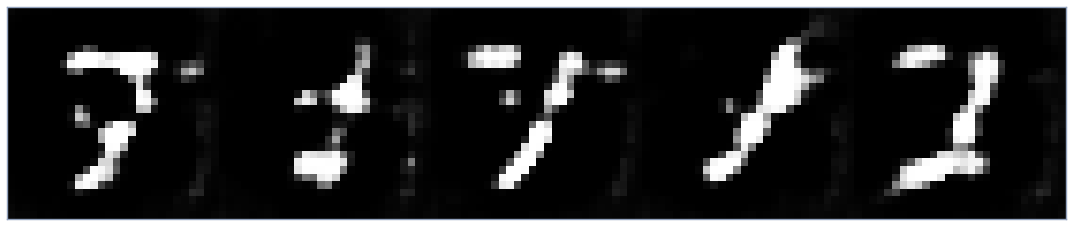

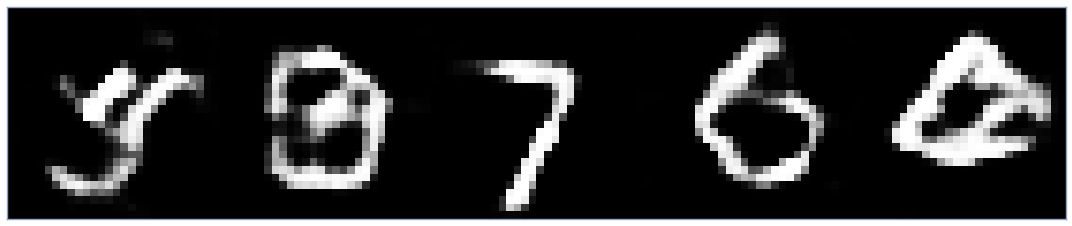

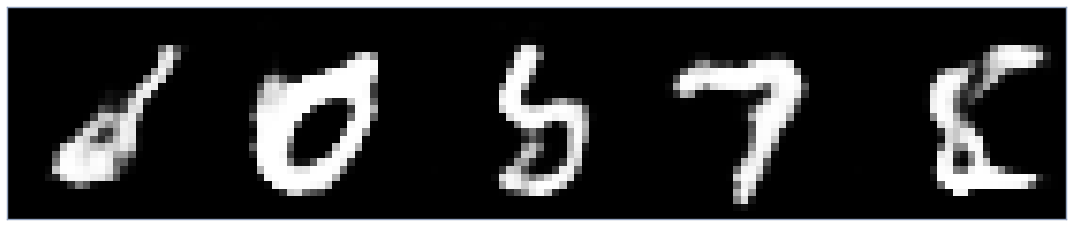

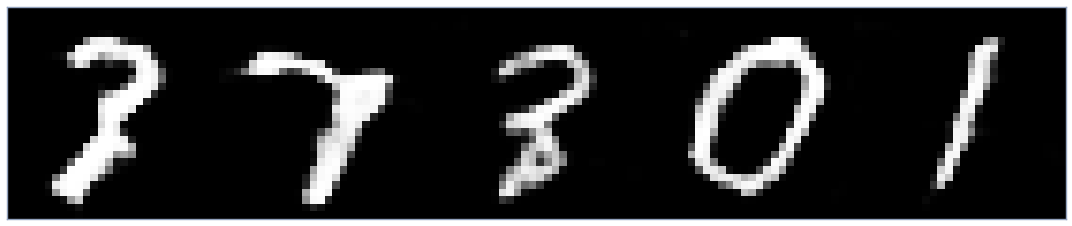

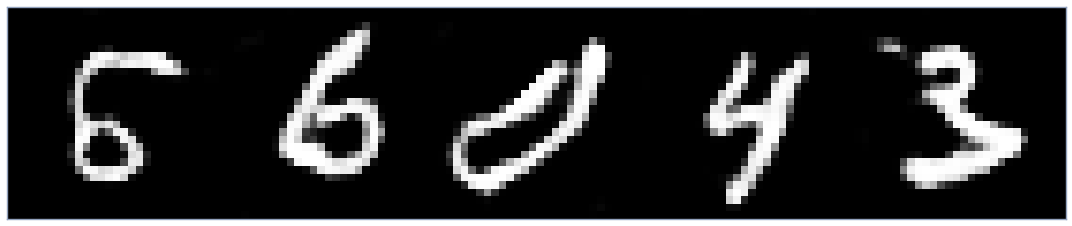

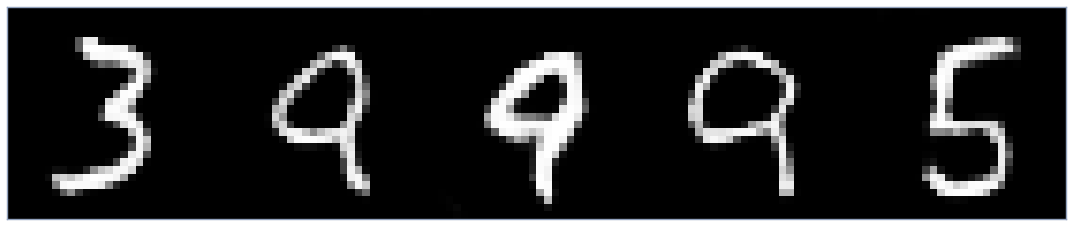

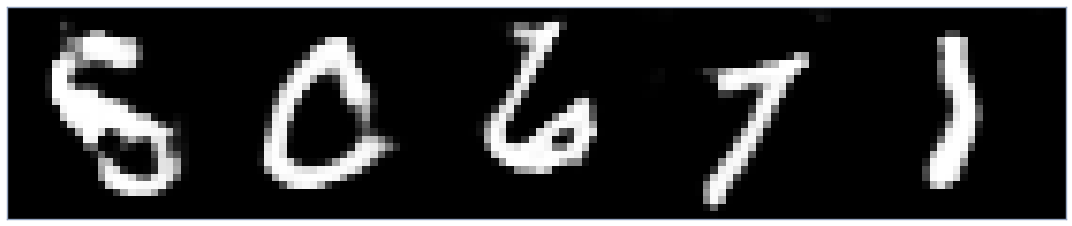

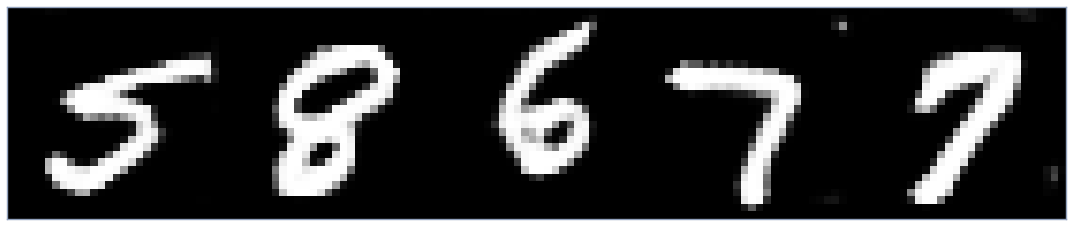

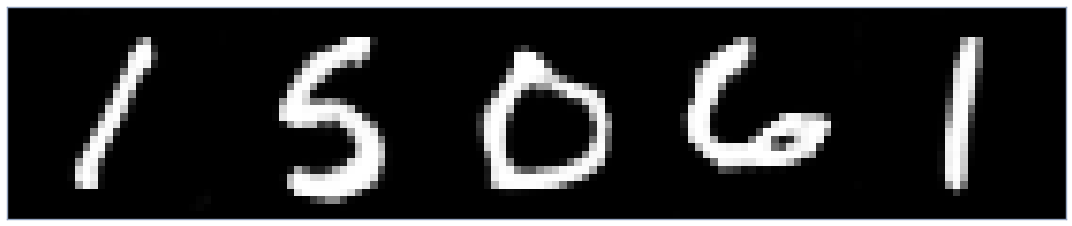

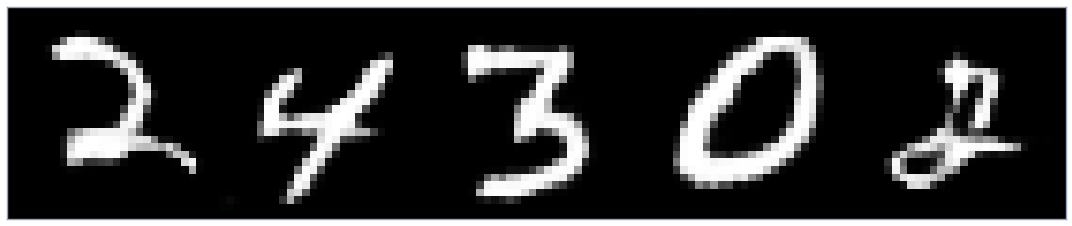

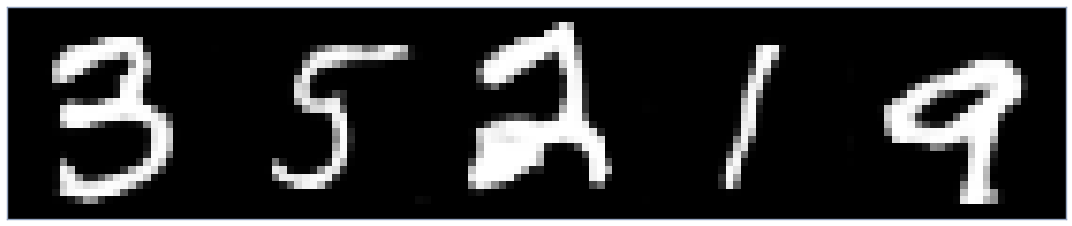

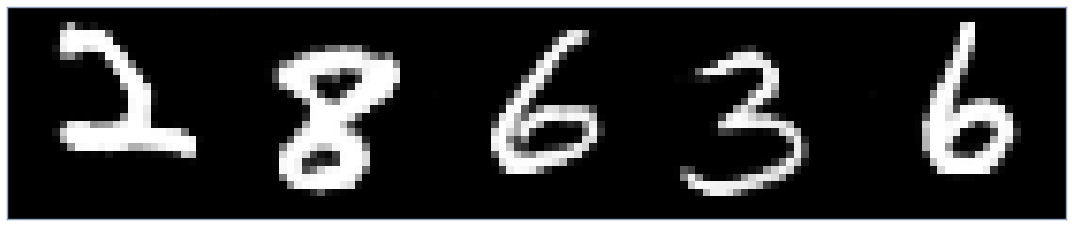

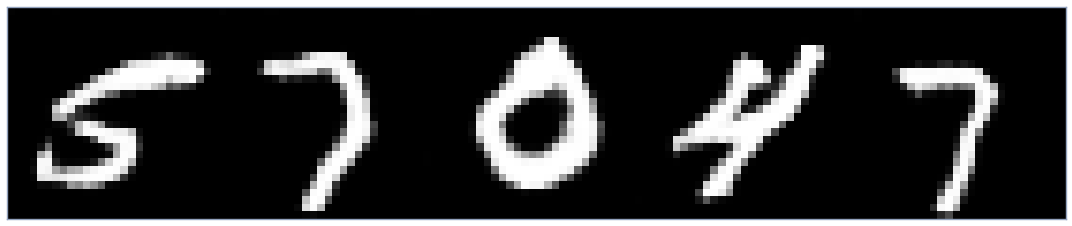

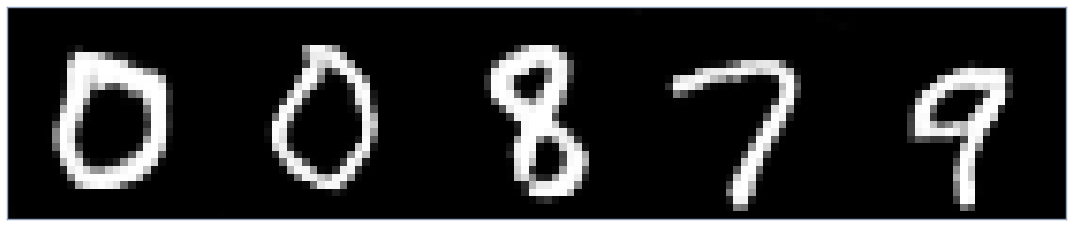

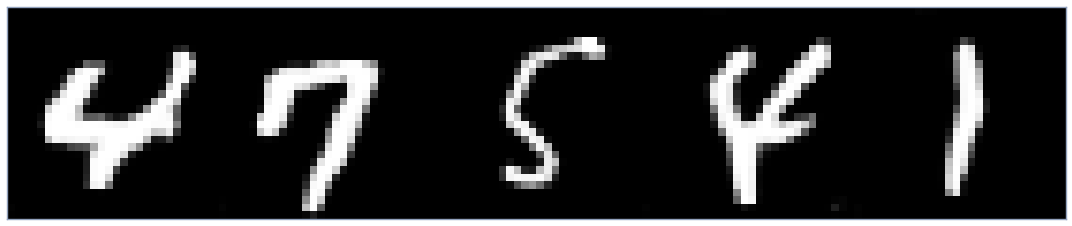

In [42]:
optimize(4)

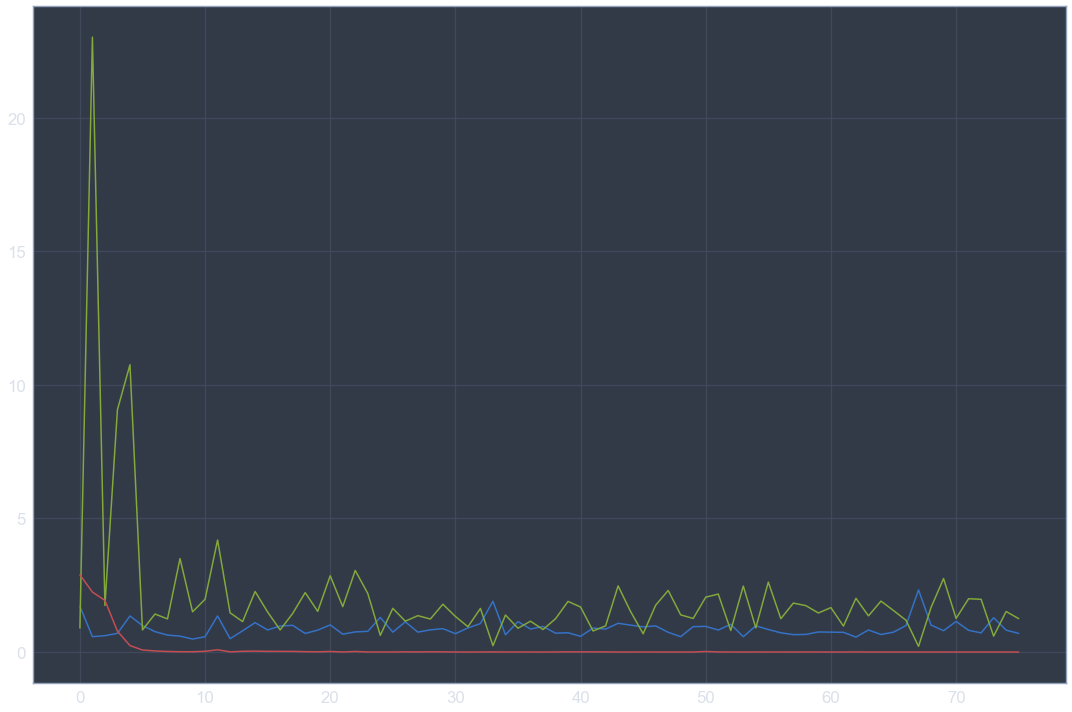

In [45]:
plot(history['loss_d'])
plot(history['loss_g'])
plot(history['loss_q'])

# Generate Images

In [18]:
generator.load_state_dict(torch.load(DIR_OUTPUT+'/generator.dat'))
discriminator.load_state_dict(torch.load(DIR_OUTPUT+'/discriminator.dat'))
q.load_state_dict(torch.load(DIR_OUTPUT+'/q.dat'))

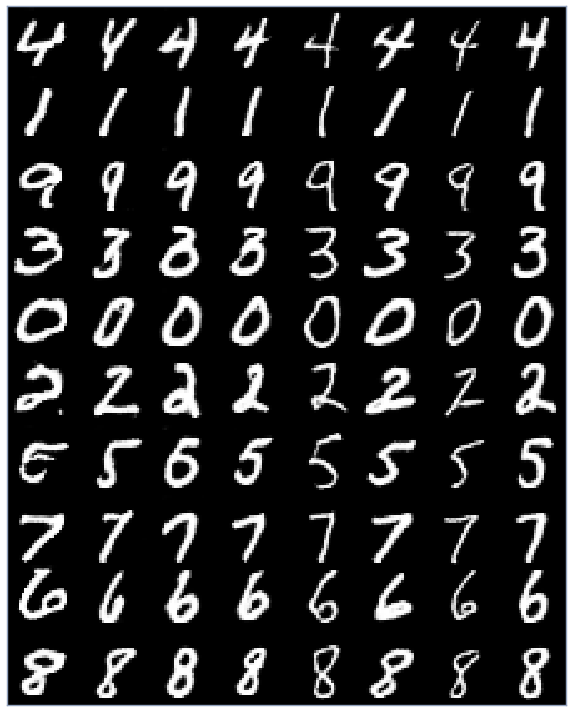

In [47]:
z_batch = Variable(torch.cat([torch.rand(8, z_dim)] * c_dim).cuda() * 2 - 1)
c_batch=[]
for _ in range(c_size):
    Variable(torch.cat([torch.multinomial(torch.Tensor([1 / c_dim] * c_dim), 8, replacement=True)] * c_dim).cuda() * 2 - 1)
    c_batch.append(Variable(torch.multinomial(torch.Tensor([1 / c_dim] * c_dim), 8*c_dim, replacement=True).cuda
                                ()))
c_batch[0] = Variable(
    torch.cat([torch.Tensor.long(torch.ones(8) * i) for i in range(c_dim)]).cuda())
x_gen = generator(z_batch, [one_hot(c, c_dim) for c in c_batch])
plot_images(channels_last(x_gen.cpu().data.numpy()), merge_shape=(10, 8))

In [46]:
torch.save(generator.state_dict(), DIR_OUTPUT+'/generator.dat')
torch.save(discriminator.state_dict(), DIR_OUTPUT+'/discriminator.dat')
torch.save(q.state_dict(), DIR_OUTPUT+'/q.dat')